In [1]:
from frgpascal.hardware.sampletray import Tray1, Tray2
from frgpascal.hardware.liquidlabware import TipRack, LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions
from frgpascal.experimentaldesign.helpers import build_sample_list
from frgpascal.experimentaldesign.tasks import *
from frgpascal.experimentaldesign import characterizationtasks as chtsk

from frgpascal.experimentaldesign.helpers import PASCALPlanner

------

# Define hardware for this experiment

## Liquid Labware 

Include _all possible_ liquid storage + pipette tipracks. Later on we will narrow this down to what is required once we know what solutions and volumes we need.

Versions are defined by the same json files used to define custom labware for the Opentrons2 liquid handler. 
New labware can be defined by following https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions

The location of the labware/tiprack on the opentrons deck must be specified as well.


| Deck | Slot | Layout |
| ----------- | ----------- | ----------- |
| 10      | 11       | _Trash_ |
| 7   | 8        | 9 |
|4 | 5 | 6|
|1 | _Spin_ | _Coater_|


For partially consumed tip racks, the `starting_tip` argument can be used to specify the first available tip. Tips before this assumed to be used up. (moves down->right, like A1, B1...H1, A2, B2 etc). If this argument is omitted, we assume to start at tip A1

In [2]:
print('\nAvailable Liquid Labwares:')
for v in liquid_labware_versions:
    print(f'\t{v}')


Available Liquid Labwares:
	frg_12_wellplate_15000ul
	sartorius_safetyspace_tiprack_200ul
	greiner_96_wellplate_360ul
	frg_spincoater_v1
	perkinelmer_p235_tiprack_235ul
	frg_24_wellplate_4000ul


In [3]:
tipracks = [
    TipRack(
        version='perkinelmer_p235_tiprack_235ul', 
        deck_slot=8,
        starting_tip="F2"
    ),
    # TipRack(
    #     version='perkinelmer_p235_tiprack_235ul', 
    #     deck_slot=11,
    #     starting_tip="B1"
    # ),
    ]

the `starting_well` argument can be used to similarly specify the first available well on the tray. This is useful for mixing on partially used well plates. Note that the use order of wells differs from tips (moves right->down, like A1, A2,...A12, B1, B2 etc)

In [4]:
tray4ml = LiquidLabware(
    name='4mL_Tray1',
    version='frg_24_wellplate_4000ul',
    deck_slot=6
    )
plate96 = LiquidLabware(
    name="96wellplate",
    version="greiner_96_wellplate_360ul",
    deck_slot=5
)
tray15ml = LiquidLabware(
    name="15mL_Tray1",
    version="frg_12_wellplate_15000ul",
    deck_slot=4
)

-----

# Define Experimental Mesh

Each of the following cells defines one dimension of the experiment. After defining the individual dimensions, a full sample list will be constructed using a user-selected Design of Expeiment (DOE)

## Solutions to spincast. 

Solutions are defined using `Solution` class instances.

Chemical formula is defined with underscores between each component. If no coefficient is provided, assumes =1. Example:

``` 
SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```
Note that you can use parentheses to simplify the formulae.
``` 
SolutionRecipe(
        solutes='MA_Pb_(I0.8_Br0.2)3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```

Antisolvents are also defined using `Solution` class instances. Solutes are left empty, and molarity is unused so can be left as 1/whatever number you like.

Example:
``` 
Solution(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    )
```

Solutions that will be interchanged (for example, different absorber solutions for compositional search) should be stored in a list. This list will be used later to permute sample process variables


In [5]:
absorber_solution = Solution(
        solutes= 'FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.15_Cl0.05)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1.2,
        alias="Absorber"
   )
tray4ml.load(absorber_solution, 'A1')

In [6]:
methyl_acetate = Solution(
        solvent='MethylAcetate',
    )
tray4ml.load(methyl_acetate, 'D1')

In [7]:
# htl_ptaa = Solution(
#     solutes='PTAA',
#     solvent='Toluene',
#     molarity=1.5, #mg/mL
#     )
# tray4ml.load(htl_ptaa, 'B1')

# htl_polytpd = Solution(
#     solutes='PolyTPD',
#     solvent='Chlorobenzene',
#     molarity=1, #mg/mL
#     )
# tray4ml.load(htl_polytpd, 'B2')

htl_tupac = Solution(
    solutes='MEO-2PAcZ',
    solvent='IPA',
    molarity=0.6, 
    )
tray4ml.load(htl_tupac, 'B3')


In [8]:
# pfn_br = Solution(
#     solutes = 'PFNBr',
#     solvent='DMF',
#     molarity=0.5, #mg/mL
# )
# tray4ml.load(pfn_br, 'C1')

In [9]:
etl_pcbm = Solution(
    solutes='PCBM',
    solvent='Chlorobenzene',
    molarity=30, #mg/mL
)
tray4ml.load(etl_pcbm, 'C2')


## Annealing steps

In [10]:
anneal_absorber = Anneal(
    temperature=100,
    duration=30*60, #30 minutes
)

anneal_htl = Anneal(
    temperature=100,
    duration=10*60, #10 minutes
)

anneal_pcbm = Anneal(
    temperature=100,
    duration=5*60, #5 minutes
)


## Spincoating Recipes


Spincoating recipes are defined using the `Spincoat` object. This takes two arguments: `steps`,a nested list of [speed, acceleration, duration] spin steps, and `drops`, a list of `Drop` objects that capture the details of each solution drop during spincoating. 

```
Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops=[
            Drop(
                solution=target_solutions[0],
                volume=20, # uL
                time=5, # seconds from start of spincoating
                height=2, # mm above substrate to dispense from, optional
                rate=50, # dispense rate (uL/sec), optional
                pre_mix=3, #number of sequential aspirate->dispense cycles to mix solution prior to aspiration, optional
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                rate=150,
                time=30,
                reuse_tip=True #whether to reuse this pipette tip (only uses tips previously used for the same solution.)
            )
        ]
    )
```

often we will be using many solutions with the same spincoating recipe. In these cases, the `solution` argument of a `Drop` object can just be a string. This string can be substituted by a list of solutions at the final step. Example:

```
spincoat_recipes = [
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution', # we will fill any Drop solutions labeled as 'psk_solution' later
                volume=20,
                time=5,
                pre_mix=3,
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                rate=150,
                time=40,
                reuse_tip=True,
            )
        ]
    ),
```

#### Defining spincoating parameters

In [26]:
# spincoat_absorber_highvolume = Spincoat(
#         steps=[
#             [1000,200,5], #speed (rpm), acceleration (rpm/s), duration (s)
#             [5000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
#         ],
#         drops = [
#             Drop(
#                 solution=absorber_solution,  #this will be filled later using the list of psk solutions
#                 volume=80,
#                 time=1,
#                 blow_out=True
#             ),
#             Drop(
#                 solution=methyl_acetate,
#                 volume=80,
#                 time=28,
#                 reuse_tip=True,
#                 touch_tip=False,
#                 rate=80,
#                 pre_mix=(3,100),
#                 slow_travel=True,
#                 blow_out=False
#             )
#         ],
#         immediate=True
#     )

spincoat_absorber_lowvolume = Spincoat(
        steps=[
            [1000,200,5], #speed (rpm), acceleration (rpm/s), duration (s)
            [5000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=absorber_solution,  #this will be filled later using the list of psk solutions
                volume=40,
                time=-1,
                blow_out=True
            ),
            Drop(
                solution=methyl_acetate,
                volume=80,
                time=28,
                reuse_tip=True,
                touch_tip=False,
                rate=80,
                pre_mix=(3,100),
                slow_travel=True,
                blow_out=False
            )
        ],
        immediate=True
    )

In [27]:
spincoat_htl = Spincoat(
        steps = [
            [5000,500,30], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution='htl',
                volume=30,
                time=-5,
                reuse_tip = True,
                blow_out=True,
                pre_mix = (3,100)
            )
        ]
    )

# spincoat_pfnbr = [
#     Spincoat(
#         steps = [
#             [5000, 2000, 20], #speed (rpm), acceleration (rpm/s), duration (s)
#         ],
#         drops = [
#             Drop(
#                 solution=pfn_br,
#                 volume=20,
#                 time=-1, #static
#                 reuse_tip=True,
#             )
#         ]
#     ),
# ]


In [38]:
rpm_sqrts = np.linspace(np.sqrt(1000), np.sqrt(5000), 7)
rpms = rpm_sqrts**2

spincoat_etl_sweep = [
    Spincoat(
        steps = [
            [rpm,1000,40], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=etl_pcbm,
                volume=20,
                time=2,
                pre_mix = (3,100)
            )
        ]
    )
    for rpm in rpms]

spincoat_etl_1krpm = Spincoat(
        steps = [
            [1000,1000,40], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=etl_pcbm,
                volume=20,
                time=2,
                pre_mix = (3,100)
            )
        ]
    )

## Characterize Absorber

In [39]:
char_absorber = Characterize(
    tasks = [
        chtsk.Brightfield(),
        # chtsk.PLPhotostability(
        #     exposure_time = 0.2,
        #     duration=30
        # ),
        chtsk.PLSpectroscopy(
            exposure_times=[1, 5, 20],
            num_scans=1
        ),
        chtsk.TransmissionSpectroscopy(
            exposure_times=[0.1, 0.5, 2, 10],
        ),
        chtsk.Darkfield(),
        chtsk.PLImaging(
            num_frames=10,
        )
    ]
)

-----

# Design of Experiment

We will input all the values defined above into `build_sample_list` to generate a sample list. Currently only a full-factorial design is implemented. 
The arguments for `build_sample_list` are as follows:
- `input_substrates`: list of substrates (strings) describing the unique starting substrates
- `steps`: worklist of process steps (`Spincoat`, `Anneal`, `Rest`, or `Characterize`) **in desired order of completion**. Each of the list elements can be a single step (if the step does not change across samples), or a list of steps of the same kind (for example, a list of spincoat variations)
- `solution_mesh`: a dictionary used to fill in solution placeholders in `Drop` objects. Keys should match the placeholder strings, and values should be lists of `Solution` objects to put into the `Drop` object.
- `n_repeats`: number of duplicates to run for each unique worklist

arguments are lists defined above, and n_repeats is the number of times to repeat each unique combination of conditions

In [40]:
samples_cells = build_sample_list(
    input_substrates = ['FTO'],
    steps = [
        spincoat_htl,
        # anneal_htl,
        # Rest(60),
        spincoat_absorber_lowvolume, 
        anneal_absorber, 
        Rest(180), 
        char_absorber,
        spincoat_etl_sweep,
        anneal_htl
    ],
    solution_mesh = dict(
        htl = [htl_tupac]
    ),
    n_repeats=2,
)
samples_forevapetl = build_sample_list(
    input_substrates = ['FTO'],
    steps = [
        spincoat_htl,
        # anneal_htl,
        # Rest(60),
        spincoat_absorber_lowvolume, 
        anneal_absorber, 
        Rest(180), 
        char_absorber
    ],
    solution_mesh = dict(
        htl = [htl_tupac]
    ),
    n_repeats=15,
)

samples = samples_cells + samples_forevapetl

## Define Stock Solutions

These are the solutions that you will be mixing to (hopefully) cover your target solutions. If they don't work, the code will tell you, and you can come back to this point and try again.

In [41]:
planner = PASCALPlanner(
    name='SAM PIN PCBM Sweep',
    description='Cells with MEO2PAcZ, sweeping down PCBM thickness. Also some bottom half cells for Apoorva to evaporate C60/BCP/Ag',
    operator='REK',
    samples=samples,
    sample_trays=[
        Tray1(), 
        # Tray2()
    ],
    tip_racks = [
        TipRack(
            version='perkinelmer_p235_tiprack_235ul', 
            deck_slot=8,
            starting_tip="F2"
        ),
    ],
    solution_storage = [
        tray4ml,
    ],
    stock_solutions = [
        absorber_solution,
        # htl_polytpd,
        # htl_ptaa,
        htl_tupac,
        etl_pcbm,
        # pfn_br,
        methyl_acetate
    ],
)

In [42]:
planner.process_solutions(
    min_volume = 50, # extra volume (uL) to add for each solution
    strategy = 'prefer_stock' #prefer_stock or least_inputs
)

===== Stock Prep =====
1210.00 of Absorber
330.00 of 30M PCBM in Chlorobenzene
920.00 of 0.6M MEO-2PAcZ in IPA
2370.00 of MethylAcetate


intermediate solution status: FEASIBLE
previous solution still valid - add new protocols before solving again
solution status: FEASIBLE
schedule image saved to "schedule_SAM PIN PCBM Sweep.jpeg"


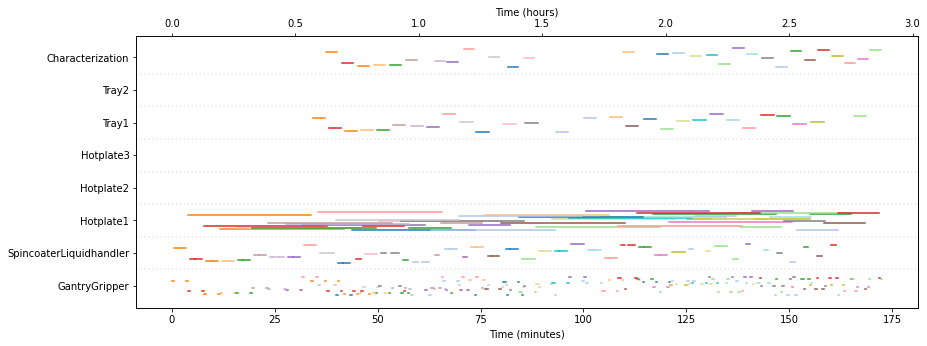

In [43]:
planner.solve_schedule(
    shuffle=True, #randomize process order
    solve_time = 10 #time (s) to spend finding a solution. 
)

OT2 protocol dumped to "./OT2PASCALProtocol_SAM PIN PCBM Sweep.py"
Maestro Netlist dumped to "maestronetlist_SAM PIN PCBM Sweep.json"
Sample dataframe dumped to "sampledataframe_SAM PIN PCBM Sweep.csv"


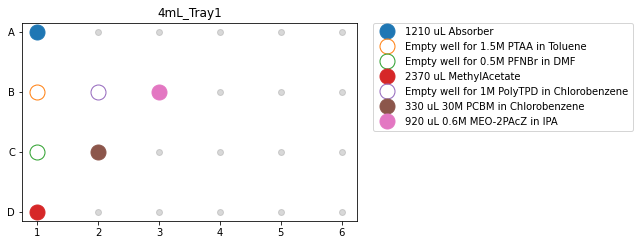

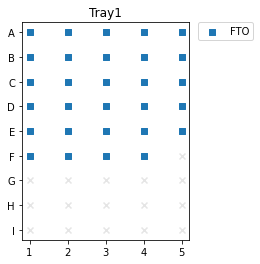

In [44]:
planner.export()